## Les selvsamlede data inn i python

I denne oppgaven ser vi videre på datasettet som Ragnhild Hannaas har hentet inn. Vi sammenlignet dataverdiene med verdier fra Seklima.met.no i oppgaven [Del4_les_csv_fil](https://github.com/irendundas/EkteData/blob/main/NAT624/Del4_les_csv_fil.ipynb), og nå ser vi videre på hvordan man kan behandle feil eller mangler i et datasett. Datasettet er på samme format som datasettene NAT624-studentene samler inn selv.

**Importer pakkene du trenger og last inn datasettet med Pandas**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Endre denne stien til der du har EkteData filene på din PC
sti='W:/Work/Documents/EkteData/EkteData/data'
# Endre dette filnavnet til det du har kalt filen du nettopp lastet ned. 
fil='/4-6_januar_Temperaturegistrering_AB-vei.csv'

Husk at du finner informasjon om hvordan man leser inn csv-filer i python i både forrige oppgave [Del4_les_csv_fil.ipynb](https://github.com/irendundas/EkteData/blob/main/NAT624/Del4_les_csv_fil.ipynb), i oversikten over [huskeregler](https://github.com/irendundas/EkteData/blob/main/Kom_i_gang/Huskeregler.ipynb), og i dokumentasjonen til funksjonen [her](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html).

In [3]:
df=pd.read_csv(
    sti+fil, sep=',', engine='python',
    parse_dates=['Time'], 
    encoding= 'unicode_escape'
)

In [4]:
df

,Temp AB-vei,Time,Celsius(°C),Comments,Serial Number
0,1,2022-01-04 15:00:00,4.0,NaN,60039020.0
1,2,2022-01-04 15:01:00,4.0,NaN,NaN
2,3,2022-01-04 15:02:00,4.0,NaN,NaN
3,4,2022-01-04 15:03:00,4.0,NaN,NaN
4,5,2022-01-04 15:04:00,4.0,NaN,NaN
...,...,...,...,...,...
2569,2570,2022-01-06 09:49:00,9.5,NaN,NaN
2570,2571,2022-01-06 09:50:00,10.5,NaN,NaN
2571,2572,2022-01-06 09:51:00,11.0,NaN,NaN
2572,2573,2022-01-06 09:52:00,12.0,NaN,NaN


Konverter pandas DataFramen til et numpy array. Dette tar hånd om tidsaksen bedre når man plotter. 

In [5]:
data=df.to_numpy()

In [6]:
data

array([[1, Timestamp('2022-01-04 15:00:00'), 4.0, nan, 60039020.0],
       [2, Timestamp('2022-01-04 15:01:00'), 4.0, nan, nan],
       [3, Timestamp('2022-01-04 15:02:00'), 4.0, nan, nan],
       ...,
       [2572, Timestamp('2022-01-06 09:51:00'), 11.0, nan, nan],
       [2573, Timestamp('2022-01-06 09:52:00'), 12.0, nan, nan],
       [2574, Timestamp('2022-01-06 09:53:00'), 12.5, nan, nan]],
      dtype=object)

Lagre tidskolonnen og temperaturkolonnen i hver sine vektorer: `tid` og `temp`

In [7]:
tid=np.copy(data[:,1])
temp=np.copy(data[:,2])

## Del 1: Oppdag avvik i et datasett
Lag en figur for å inspisere datasettet. 

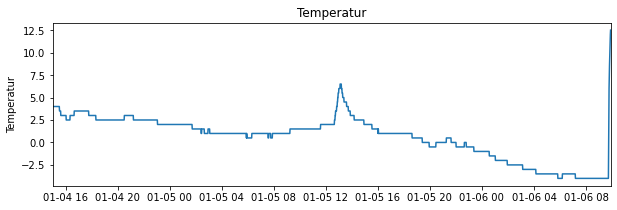

In [8]:
plt.figure(figsize=(10,3))
plt.plot(tid,temp)
plt.xlim(tid[0], tid[-1])
plt.title('Temperatur')
plt.ylabel('Temperatur')
plt.show()

Dette ser litt rart ut - her trenger vi å vite litt om datainnhentingsprosessen for å forstå hva som må forklares av feilkilder og hva som er faktiske temperaturendringer. 

**Mulig feilkilde nr 1**
Det er for eksempel to hopp i temperatur: ett etter kl 12 den 5. januar, og ett helt på slutten av tidsserien. Er instrumentet blitt flyttet? Lå instrumentet i skyggen eller i solen? Når man samler inn data er det viktig å holde oversikten over slike forhold som kan påvirke datasettet, for eksempel notere ting ned i en log-bok. Man vet ikke alltid hva slags detaljer man kan ha nytte av å ha notert ned i etterkant, så noter heller litt mye enn litt lite.  

**Mulig feilkilde nr 2**
En annen ting som kan være lurt å sjekke om man bruker et instrument man ikke kjenner til så godt er om den har lagret data med konstant frekvens. I figuren over ser det ut som om at noen perioder har høyere oppløsning enn andre. Er det hull i datasettet eller er bare temperaturen veldig jevn i noen perioder? `Pandas` har en funksjon for å sjekke dette: `pd.infer_freq()`.

In [9]:
# Resultatet er 'T', altså er det konstant frekvens på timesoppløsning.
pd.infer_freq(df['Time'])

'T'

Datapunktene har altså jevn frekvens, så feilkilde nr 2 er ikke en faktisk feilkilde, dataveridiene er bare veldig jevne i perioder. 

## Oppgave 1
Hvorfor er det viktig å identifisere slike feil i datasettet? Hva slags feil kan man få om man ikke oppdager dette? 

Beregn gjennomsnittstemperatur og standardavvik til den ubehandlede temperatur-tidsserien. Finn også medianen. Det har vi ikke beregnet før, så her trengs et google-søk. Lengre ned ser vi på forskjellen etter at datasettet er behandlet. 

In [10]:
np.median(temp), np.mean(temp), np.std(temp)

(1.0, 0.5864413364413364, 2.3583010493594996)

### Del 2: Hvordan behandle slike avvik?

De tre metodene under er alle gyldige og gode. Hvilken metode man bruker må man vurdere ut ifra avviket og datasettet. 
- sett ugyldige verdier til NaN
- erstatt ugyldige verdier med gjennomsnittsverdier
- fjern de ugyldige verdiene og interpoler med en funksjon

Ofte er det en god løsning å sette verdier man mangler eller er usikre på om er gyldige til `NaN`. Da får man et hull i datasettet sitt, men det er bedre å basere et gjennomsnitt på litt færre verdier eller å ha et hull i en figur, enn å bruke verdier man vet man ikke kan stole på. 


### Del 3: sett spiken i slutten av datasettet til NaN
Den siste "spiken" i figuren over er et tilfelle hvor det er en god ide å sette verdien til `NaN`. Siden det er helt på slutten av tidsserien har det veldig lite å si å fjerne disse datapunktene. Første steg er å finne verdiene som må settes til `NaN` for å få fjernet denne spiken. 

**Metode 1**: Siden dette er et så lite datasett kan man inspisere de siste verdiene for å finne hva man vil sette til NaN.

In [11]:
temp[-20:]

array([-4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -0.5,
       3.5, 6.0, 7.5, 8.5, 9.5, 10.5, 11.0, 12.0, 12.5], dtype=object)

In [12]:
temp[-10:]

array([-0.5, 3.5, 6.0, 7.5, 8.5, 9.5, 10.5, 11.0, 12.0, 12.5],
      dtype=object)

In [13]:
# Jeg setter de siste 10 verdiene til NaN: det er lenge stabilt 
# på -4 før det begynner å øke
temp[-10:]=np.nan

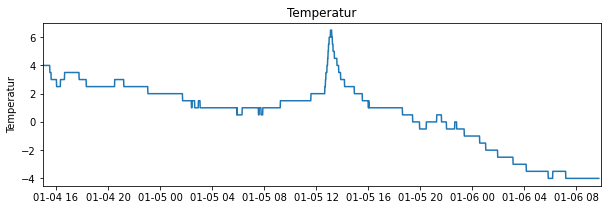

In [14]:
plt.figure(figsize=(10,3))
plt.plot(tid,temp)
plt.xlim(tid[0], tid[-1])
plt.title('Temperatur')
plt.ylabel('Temperatur')
plt.show()

In [15]:
temp[-20:]

array([-4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=object)

**Metode 2: Hva om det ikke er praktisk mulig å fikse det manuelt?**

Hadde dette vært et større datasett ville ikke manuell inspeksjon fungert. Det samme gjelder om det var flere slike spiker. En fremgangsmåte som kan fungere er å finne hvor det skjer store endringer i verdier. Dette vil identifisere spiker. Vi prøver:

In [16]:
# Last inn temp på nytt for et nytt forsøk:
temp=np.copy(data[:,2])

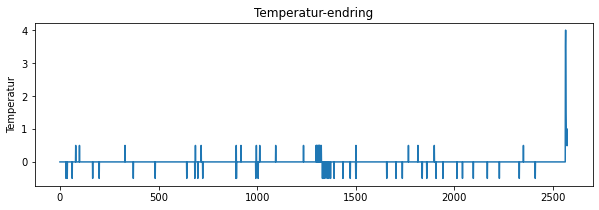

In [17]:
# plot differansen mellom hvert datapunkt med np.diff():
plt.figure(figsize=(10,3))
diff=np.diff(temp)
plt.plot(diff)
plt.title('Temperatur-endring')
plt.ylabel('Temperatur')
plt.show()

Figuren over viser hvor mye temperaturen endrer seg mellom hvert tidssteg. Dette kan hjelpe oss med å sette en grense for hvor mye endring vi ser på som fysisk realistisk. Jeg velger å sette grensen på 1 grad mellom hvert tidssteg.

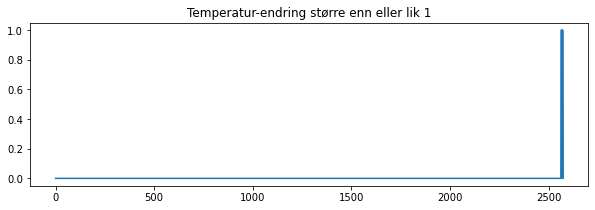

In [18]:
plt.figure(figsize=(10,3))
# plot kun indeksene der diff er større enn eller lik 1
plt.plot(diff>=1)
plt.title('Temperatur-endring større enn eller lik 1')
plt.show()


Alle disse tilfellene er konsentrert i slutten av tidsserien, som forventet siden det er der vi ser den største spiken. 

Nå trenger vi å vite indeksen til tidsstegene med større temperaturendring enn 1 grad. 

In [19]:
diff>=1

array([False, False, False, ..., False,  True, False])

Dette er en lang liste med enten `True` eller `False`. Der diff er strørre eller lik 1 står det `True`. Vi kan nå finne indeksene der `diff>=1` er `True` med funksjonen `np.where()` som vi er kjent med fra tidligere, f.eks. i [oppgave 2](https://github.com/irendundas/EkteData/blob/main/NAT624/Del2_Indeksering.ipynb).

In [20]:
np.where((diff>=1)==True)

(array([2563, 2564, 2565, 2566, 2567, 2568, 2569, 2571], dtype=int64),)

Vi setter alle verdiene fra og med den første ugyldige verdiene til NaN

In [21]:
nanid=np.where((diff>=1)==1)[0][0]
nanid

2563

In [22]:
temp[nanid:]=np.nan

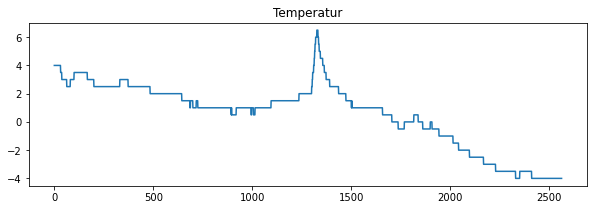

In [23]:
plt.figure(figsize=(10,3))
plt.plot(temp)
plt.title('Temperatur')
plt.show()

I dette tilfelle virket kanskje ikke dette så effektivt i forhold til den manuelle metoden, men hvis det var mange spiker strødd ut i datsettet hadde metode 2 absolutt vært mest effektiv fordi man finner indeksene til de ugyldige verdiene automatisk heller enn med inspeksjon. 


### Del 4: spiken i midten av tidsserien

Men hva med **spiken i midten av tidsserien**? Denne er ikke like lett å identifisere i tid: Endringen er ikke så sterk som spiken på slutten var, og verdiene er ikke så høye. Siden tidsseriene vi jobber med i dette kurset generelt ikke er så lange identifiserer vi denne manuelt og ser på tre forskjellige måter å behandle disse datapunktene:
- sett til NaN
- sett til gjennomsnittet av punktene ved siden
- bruk en funksjon til å interpolere. 

Om det ikke var praktisk mulig å identifisere spiken manuelt måtte vi laget en metode (en algoritme) som identifiserte den for oss. I figuren over differanse har f.eks. mange tidssteg på rad stor differanse der midt-spiken er. Dette kunne vært et kritere i en slik algoritme. 

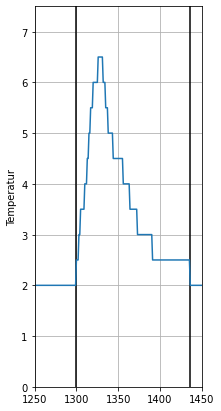

In [24]:
plt.figure(figsize=(3,7))
plt.plot(temp)
plt.grid()
plt.xlim(1250, 1450)
plt.ylim(0, 7.5)

plt.vlines(1299, 0, 7.5, 'k')
plt.vlines(1436, 0, 7.5, 'k')
plt.ylabel('Temperatur')
plt.show()

Vi begrenser området vi vil behandle til verdiene mellom indeks 1299 og 1436. I denne manuelle metoden kan man rett og slett prøve seg frem med x-verdiene i `plt.vlines()` frem til man identifiserer grensene til spiken. 

#### Metode 1: Sett til NaN:

In [25]:
# Bruk 1436+1 for å få med den siste indeksen
temp[1299:1436+1]=np.nan

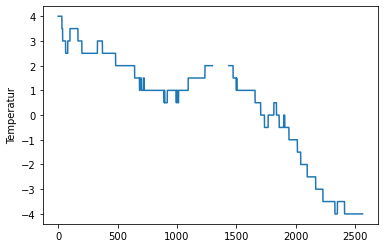

In [26]:
plt.plot(temp)
plt.ylabel('Temperatur')
plt.show()

#### Metode 2: Sett verdiene der spiken er til gjennomsnittet av punktene til sidene

Finn gjennomsnittet til punktene ved siden av. Bruk f.eks. 10 punkter fra hver side.

In [27]:
# Finn gjennomsnittet til punktene ved siden av. Bruk f.eks. 10 punkter fra hver side.
mean=np.nanmean(temp[1299-10:1437+10], dtype='float64')
mean

2.0

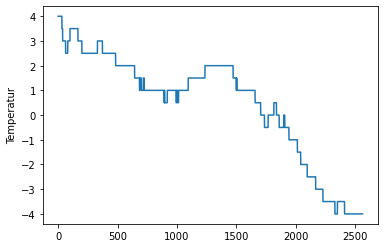

In [28]:
temp[1299:1436+1]=mean

plt.plot(temp)
plt.ylabel('Temperatur')
plt.show()

#### Metode 3: Bruk en funksjon til å interpolere

Vi bruker pandas sin fuksjon `interpolate` til å lineært interpolere `temp`. 

In [29]:
temp=np.copy(data[:,2])

# For å bruke funksjonen interpolate() må verdiene i "temp" være floats 
temp=np.array(temp, dtype='float64')

# Fjern de siste ti verdiene (den siste spiken)
temp=temp[:-10]

# Sett verdiene i den midterste spiken til NaN
temp[1299:1436+1]=np.nan

In [30]:
# Gjør arrayet "temp" om til en Pandas DataFrame slik at Pandas sine funksjoner
# kan brukes
temp=pd.DataFrame(temp)

# Lineært interpoler temp
temp=temp.interpolate()

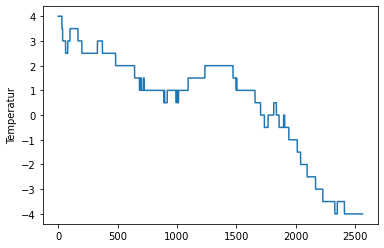

In [31]:
plt.plot(temp)
plt.ylabel('Temperatur')
plt.show()

## Oppgave 2
Konverter temp tilbake til et `Numpy` array. Finn igjen gjennomsnittet, medianen og standardsvviket til temp og sammenlign verdiene med det du fant før spikene i datasettet var tatt vekk. Var det verdt det å fjerne spikene? Hvorfor?

In [32]:
temp=temp.to_numpy()

In [33]:
np.median(temp), np.mean(temp), np.std(temp)

(1.0, 0.4676287051482059, 2.1916122530585462)

## Oppgave 3
I cellen under blir det introdusert et par ekstra feil. Identifiser feilene og bruk de metodene du vil til å fjerne dem. Du kan prøve å fjerne flere på en gang med samme metode, eller du kan fjerne ulike feil med ulike metoder. 

In [34]:
temp[:7]=11

In [35]:
temp[(temp>=-2.7)&(temp<=-2)]=-5

In [36]:
temp[temp==0.5]=-7

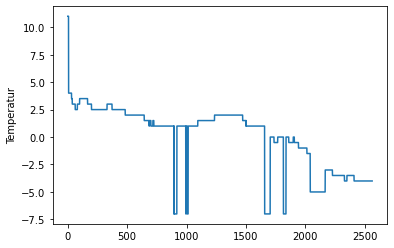

In [37]:
plt.plot(temp)
plt.ylabel('Temperatur')
plt.show()